# Telecom Churn Prediction

## Business Problem Overview
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal.


To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

 
In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.


2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)


3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
# !pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [2]:
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")

print(data.shape)
print(unseen.shape)

(69999, 172)
(30000, 171)


In [3]:
ids = ['id','circle_id']
total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]

#Storing them in a single flat list
variables = [*ids, 
             *total_amounts, 
             *total_outgoing_minutes, 
             *offnetwork_minutes, 
             *average_revenue_3g, 
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network, 
             'churn_probability']

data = data[variables].set_index('id')

In [4]:
data.head()

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
id,,,,,,,,,,,,,,,,,,,,,
0,109,77,65,10,81.21,221.68,3.63,32.24,96.68,2.33,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,1958,0
1,109,0,145,50,0.00,30.73,31.66,0.00,25.99,30.89,...,122.08,NaN,0.0,3.96,0.0,0.0,352.91,0.00,710,0
2,109,70,120,0,56.49,99.36,0.00,53.99,82.05,0.00,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,882,0
3,109,160,240,130,76.03,95.98,53.84,68.76,78.48,50.23,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,982,0
4,109,290,136,122,63.26,42.94,15.76,56.99,38.11,9.63,...,35.12,0.0,0.0,0.00,0.0,390.8,308.89,213.47,647,0


Let's look at each variable's datatype:

In [5]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69999 entries, 0 to 69998
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   circle_id          69999 non-null  int64  
 1   total_rech_amt_6   69999 non-null  int64  
 2   total_rech_amt_7   69999 non-null  int64  
 3   total_rech_amt_8   69999 non-null  int64  
 4   total_og_mou_6     69999 non-null  float64
 5   total_og_mou_7     69999 non-null  float64
 6   total_og_mou_8     69999 non-null  float64
 7   offnet_mou_6       67231 non-null  float64
 8   offnet_mou_7       67312 non-null  float64
 9   offnet_mou_8       66296 non-null  float64
 10  arpu_3g_6          17568 non-null  float64
 11  arpu_3g_7          17865 non-null  float64
 12  arpu_3g_8          18417 non-null  float64
 13  arpu_2g_6          17568 non-null  float64
 14  arpu_2g_7          17865 non-null  float64
 15  arpu_2g_8          18417 non-null  float64
 16  vol_3g_mb_6        699

Let's also summarize the features using the df.describe method:

In [6]:
data.describe(include="all")

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
count,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,...,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,109.0,328.139788,322.376363,323.846355,306.451436,310.572674,304.513065,198.874771,197.153383,196.543577,...,85.846074,86.348404,122.171882,128.934444,135.486541,51.773924,51.240204,50.127506,1220.639709,0.101887
std,0.0,404.211068,411.070120,426.181405,465.502866,479.131770,477.936832,316.818355,322.482226,324.089234,...,178.067280,170.297094,554.869965,554.096072,568.310234,212.513909,211.114667,213.101403,952.426321,0.302502
min,109.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-13.090000,-55.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000
25%,109.0,110.000000,100.000000,90.000000,44.780000,42.910000,38.710000,34.860000,32.240000,31.575000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000
50%,109.0,229.000000,220.000000,225.000000,145.280000,141.230000,138.360000,96.480000,91.885000,91.800000,...,8.800000,9.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000
75%,109.0,438.000000,430.000000,436.000000,374.305000,380.045000,370.895000,232.990000,227.630000,229.345000,...,122.070000,122.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000
max,109.0,35190.000000,40335.000000,45320.000000,10674.030000,8285.640000,14043.060000,8362.360000,7043.980000,14007.340000,...,4809.360000,3483.170000,45735.400000,28144.120000,30036.060000,10285.900000,7873.550000,11117.610000,4337.000000,1.000000


# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [7]:
data['circle_id'].unique()

array([109], dtype=int64)

In [8]:
X = data.drop(['circle_id'],1).iloc[:,:-1]
y = data.iloc[:,-1]

X.shape, y.shape

((69999, 22), (69999,))

Splitting train and test data to avoid any contamination of the test data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 22), (14000, 22), (55999,), (14000,))

In [10]:
X_train.head()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,arpu_3g_6,...,arpu_2g_6,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
id,,,,,,,,,,,,,,,,,,,,,
30385,280,380,350,255.19,288.81,284.91,152.06,176.01,181.79,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.00,0.00,0.00,278
27574,565,537,905,572.04,717.64,1100.19,163.21,212.58,461.01,0.0,...,0.01,0.01,0.0,0.0,0.0,0.0,1386.43,788.24,444.55,370
23947,240,360,625,597.19,863.38,1093.11,344.63,393.01,529.56,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.00,0.00,0.00,2766
9828,150,253,180,118.66,215.71,131.93,114.43,215.49,125.58,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.00,0.00,0.00,2516
31321,221,537,160,2627.36,350.64,96.04,57.26,119.79,58.56,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.00,0.00,0.00,242


# 3. Handling Missing data

Lets also calculate the % missing data for each column:

In [11]:
missing_data_percent = (100*X_train.isnull().sum()/len(y_train)).sort_values(ascending = False)
missing_data_percent

arpu_3g_6           74.965624
arpu_2g_6           74.965624
arpu_3g_7           74.503116
arpu_2g_7           74.503116
arpu_3g_8           73.740603
arpu_2g_8           73.740603
offnet_mou_8         5.244737
offnet_mou_6         3.941142
offnet_mou_7         3.832211
vol_3g_mb_6          0.000000
vol_2g_mb_8          0.000000
vol_2g_mb_7          0.000000
vol_2g_mb_6          0.000000
vol_3g_mb_8          0.000000
vol_3g_mb_7          0.000000
total_rech_amt_6     0.000000
total_rech_amt_7     0.000000
total_og_mou_8       0.000000
total_og_mou_7       0.000000
total_og_mou_6       0.000000
total_rech_amt_8     0.000000
aon                  0.000000
dtype: float64

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 40% missing data.

In [12]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['offnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'vol_3g_mb_6',
       'vol_2g_mb_8', 'vol_2g_mb_7', 'vol_2g_mb_6', 'vol_3g_mb_8',
       'vol_3g_mb_7', 'total_rech_amt_6', 'total_rech_amt_7', 'total_og_mou_8',
       'total_og_mou_7', 'total_og_mou_6', 'total_rech_amt_8', 'aon'],
      dtype='object')

In [14]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(55999, 16)

Next, we try imputation on variables with any amount of missing data still left.

In [15]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['offnet_mou_8', 'offnet_mou_6', 'offnet_mou_7'], dtype='object')

In [16]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

In [17]:
X_train_filtered.describe()

,offnet_mou_8,offnet_mou_6,offnet_mou_7,vol_3g_mb_6,vol_2g_mb_8,vol_2g_mb_7,vol_2g_mb_6,vol_3g_mb_8,vol_3g_mb_7,total_rech_amt_6,total_rech_amt_7,total_og_mou_8,total_og_mou_7,total_og_mou_6,total_rech_amt_8,aon
count,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000
mean,185.457489,189.861482,188.321627,122.232424,50.556140,51.391151,51.477802,134.293864,127.382967,327.262201,321.605975,303.785459,309.376794,305.665171,323.663869,1220.113359
std,311.899834,308.357539,314.167049,569.871260,216.293251,213.013724,210.381144,556.604139,551.037320,403.381691,414.496243,471.562705,475.289682,462.897385,423.485790,952.585499
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000
25%,23.600000,28.620000,26.540000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,110.000000,100.000000,38.710000,42.470000,44.590000,90.000000,468.000000
50%,82.860000,89.590000,85.340000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,220.000000,138.590000,141.130000,144.660000,225.000000,866.000000
75%,215.790000,223.210000,216.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,437.000000,430.000000,369.340000,378.150000,373.000000,436.000000,1809.000000
max,7857.780000,8362.360000,6740.080000,45735.400000,11117.610000,7873.550000,10285.900000,30036.060000,28144.120000,35190.000000,40335.000000,10882.860000,8285.640000,8488.360000,45320.000000,4337.000000


<AxesSubplot:>

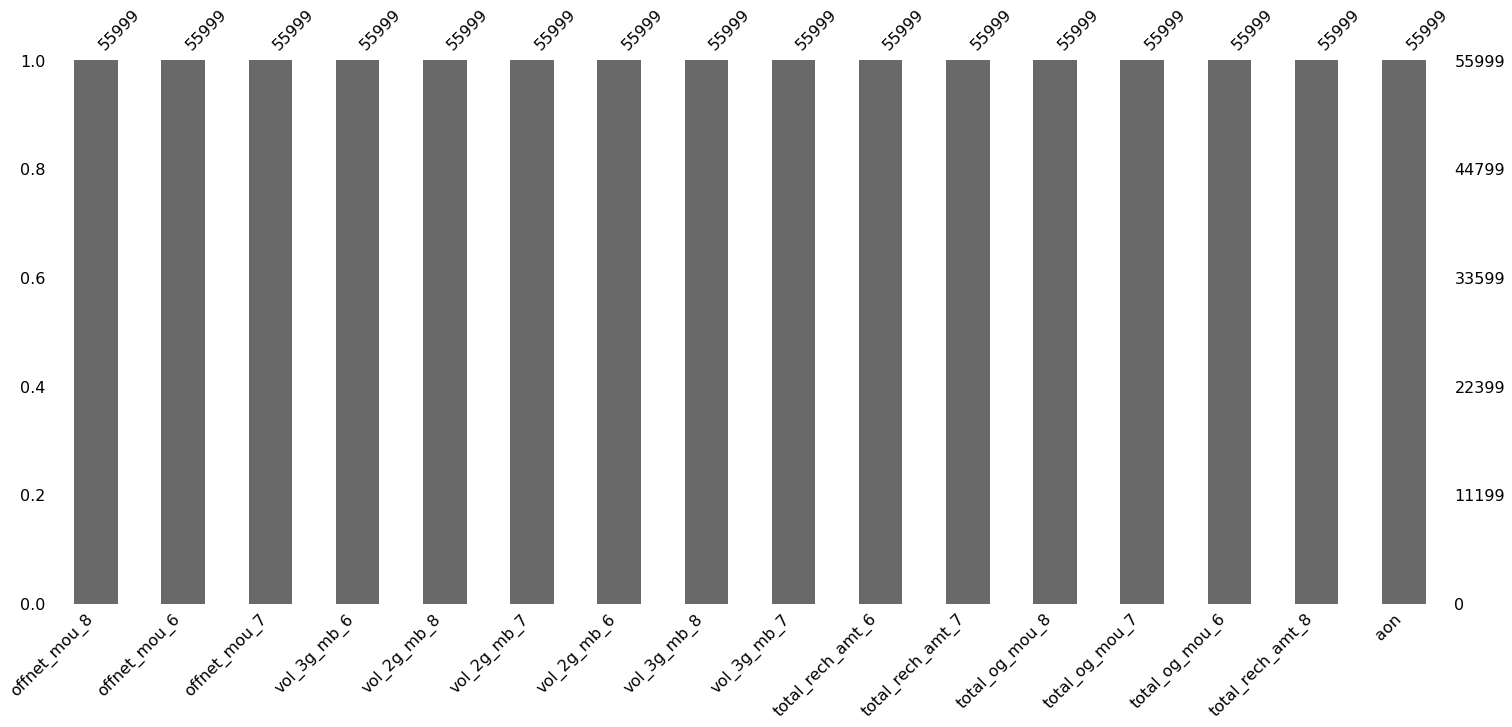

In [18]:
msno.bar(X_train_filtered)

# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<AxesSubplot:>

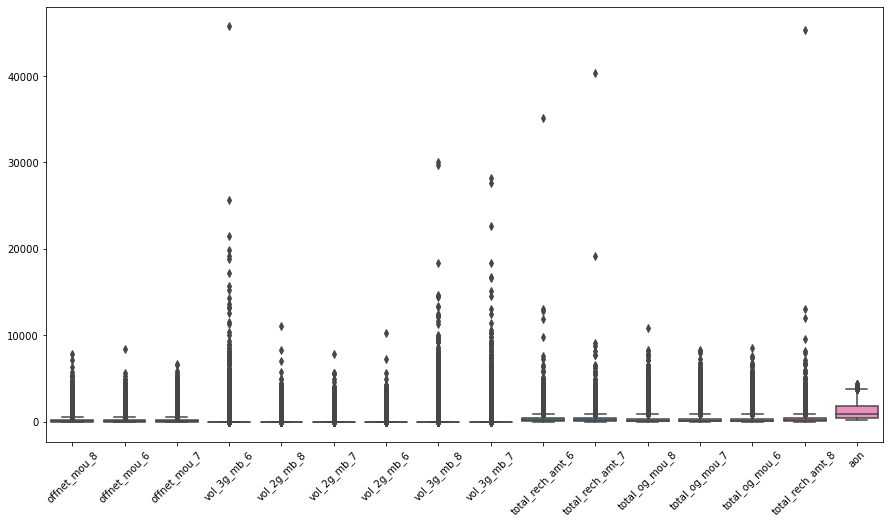

In [19]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [20]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<AxesSubplot:>

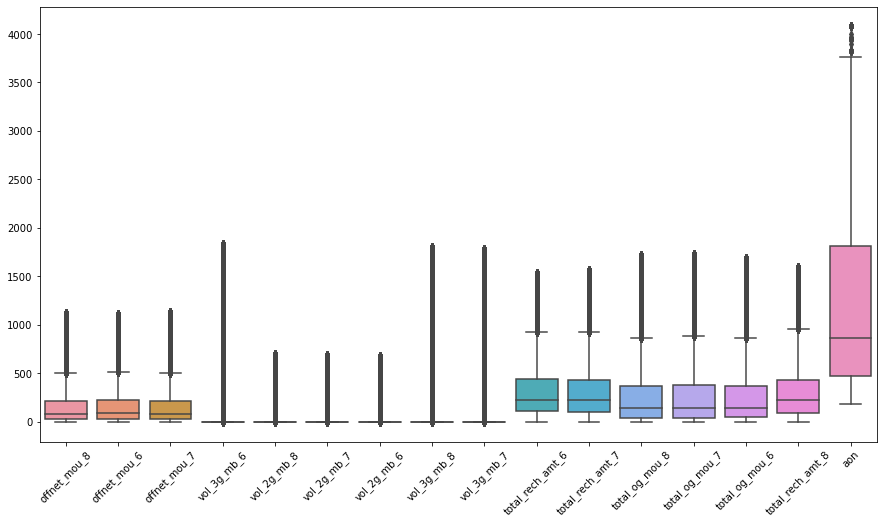

In [21]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler.

In [22]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

<AxesSubplot:>

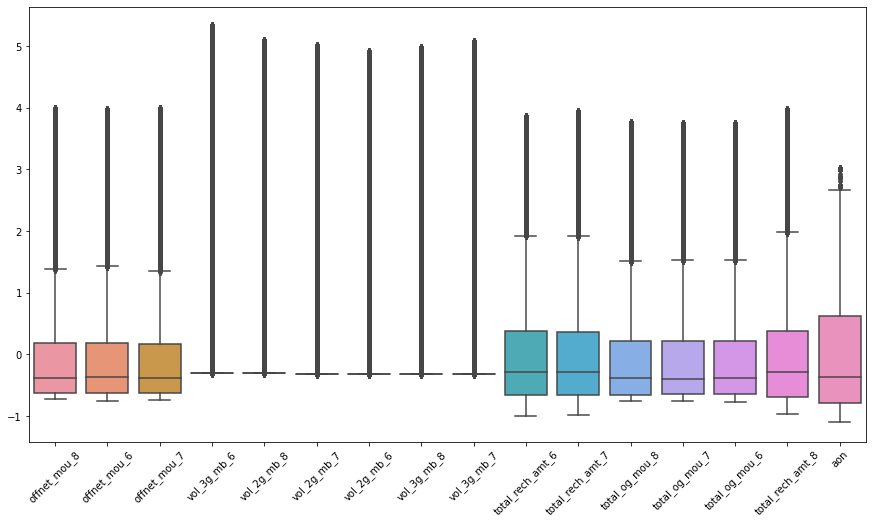

In [23]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=new_vars))

Lets also plot the correlations for each feature for bivariate analysis.

<AxesSubplot:>

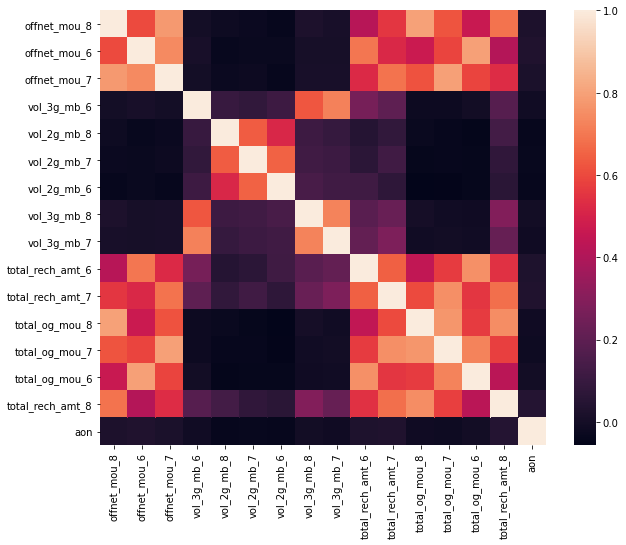

In [24]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

<AxesSubplot:xlabel='churn_probability', ylabel='Count'>

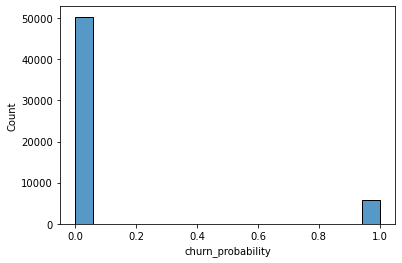

In [25]:
#Distribution for the churn probability
sns.histplot(y_train)

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [26]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

RandomForestClassifier(n_jobs=-1)

In [27]:
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})

<BarContainer object of 16 artists>

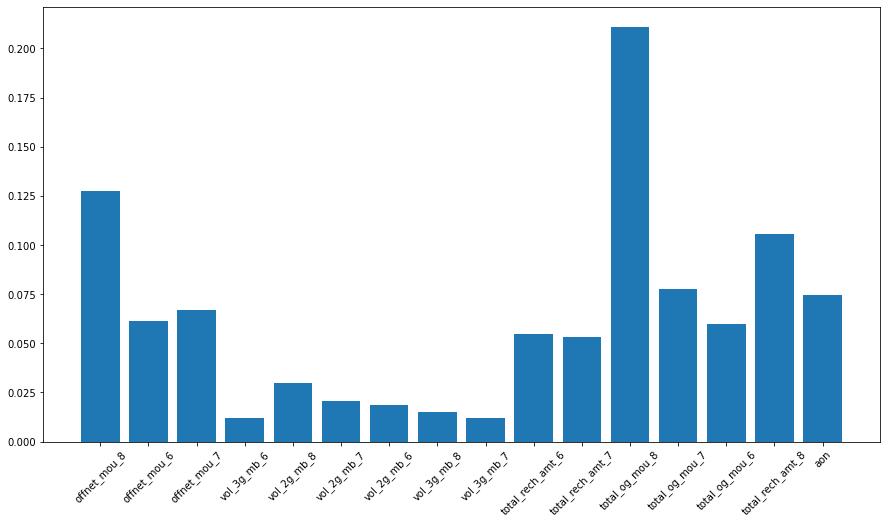

In [28]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

Way of finding good features would be to project them into a lower dimensional space using PCA. PCA creates components which are a linear combination of the features. This then allows you to select components which explain the highest amount of variance.

<AxesSubplot:>

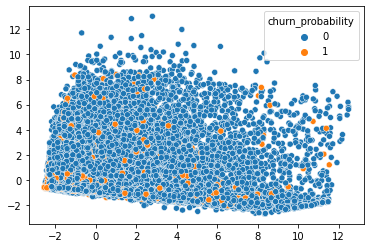

In [29]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<AxesSubplot:>

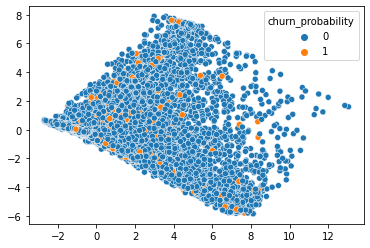

In [30]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

<BarContainer object of 16 artists>

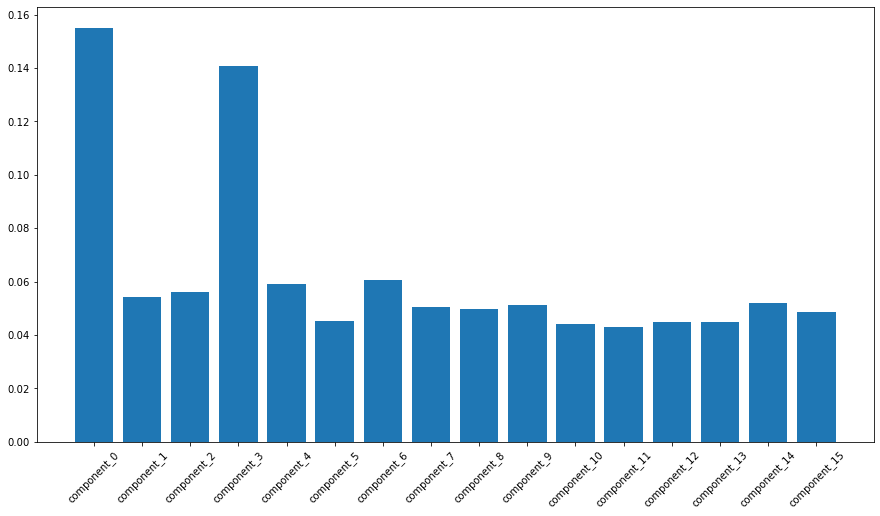

In [31]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

feature_importances = pd.DataFrame({'col':['component_'+str(i) for i in range(16)], 
                                    'importance':rf.feature_importances_})

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

# 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

In [32]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [33]:
lr.score(pca_components[:,:2], y_train)

0.8984446150824121

The model has 89.8% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following -
1. Imputation
2. Scaling
3. PCA
4. Classification model

In [34]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [35]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [36]:
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [37]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9001410739477491


In [38]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.8991428571428571


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [39]:
confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

array([[50038,   274],
       [ 5318,   369]], dtype=int64)

In [40]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[12487,    68],
       [ 1344,   101]], dtype=int64)

In [42]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

0.5976331360946746

In [43]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

0.0698961937716263

# 7. Creating submission file

In [44]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [45]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

(30000, 16)

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [46]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [49]:
output.to_csv('submission.csv',index=False)